In [1]:
import numpy as np
import matplotlib.pyplot as plt
from problem_1.FEMpoisson import FEMPoissonSolver

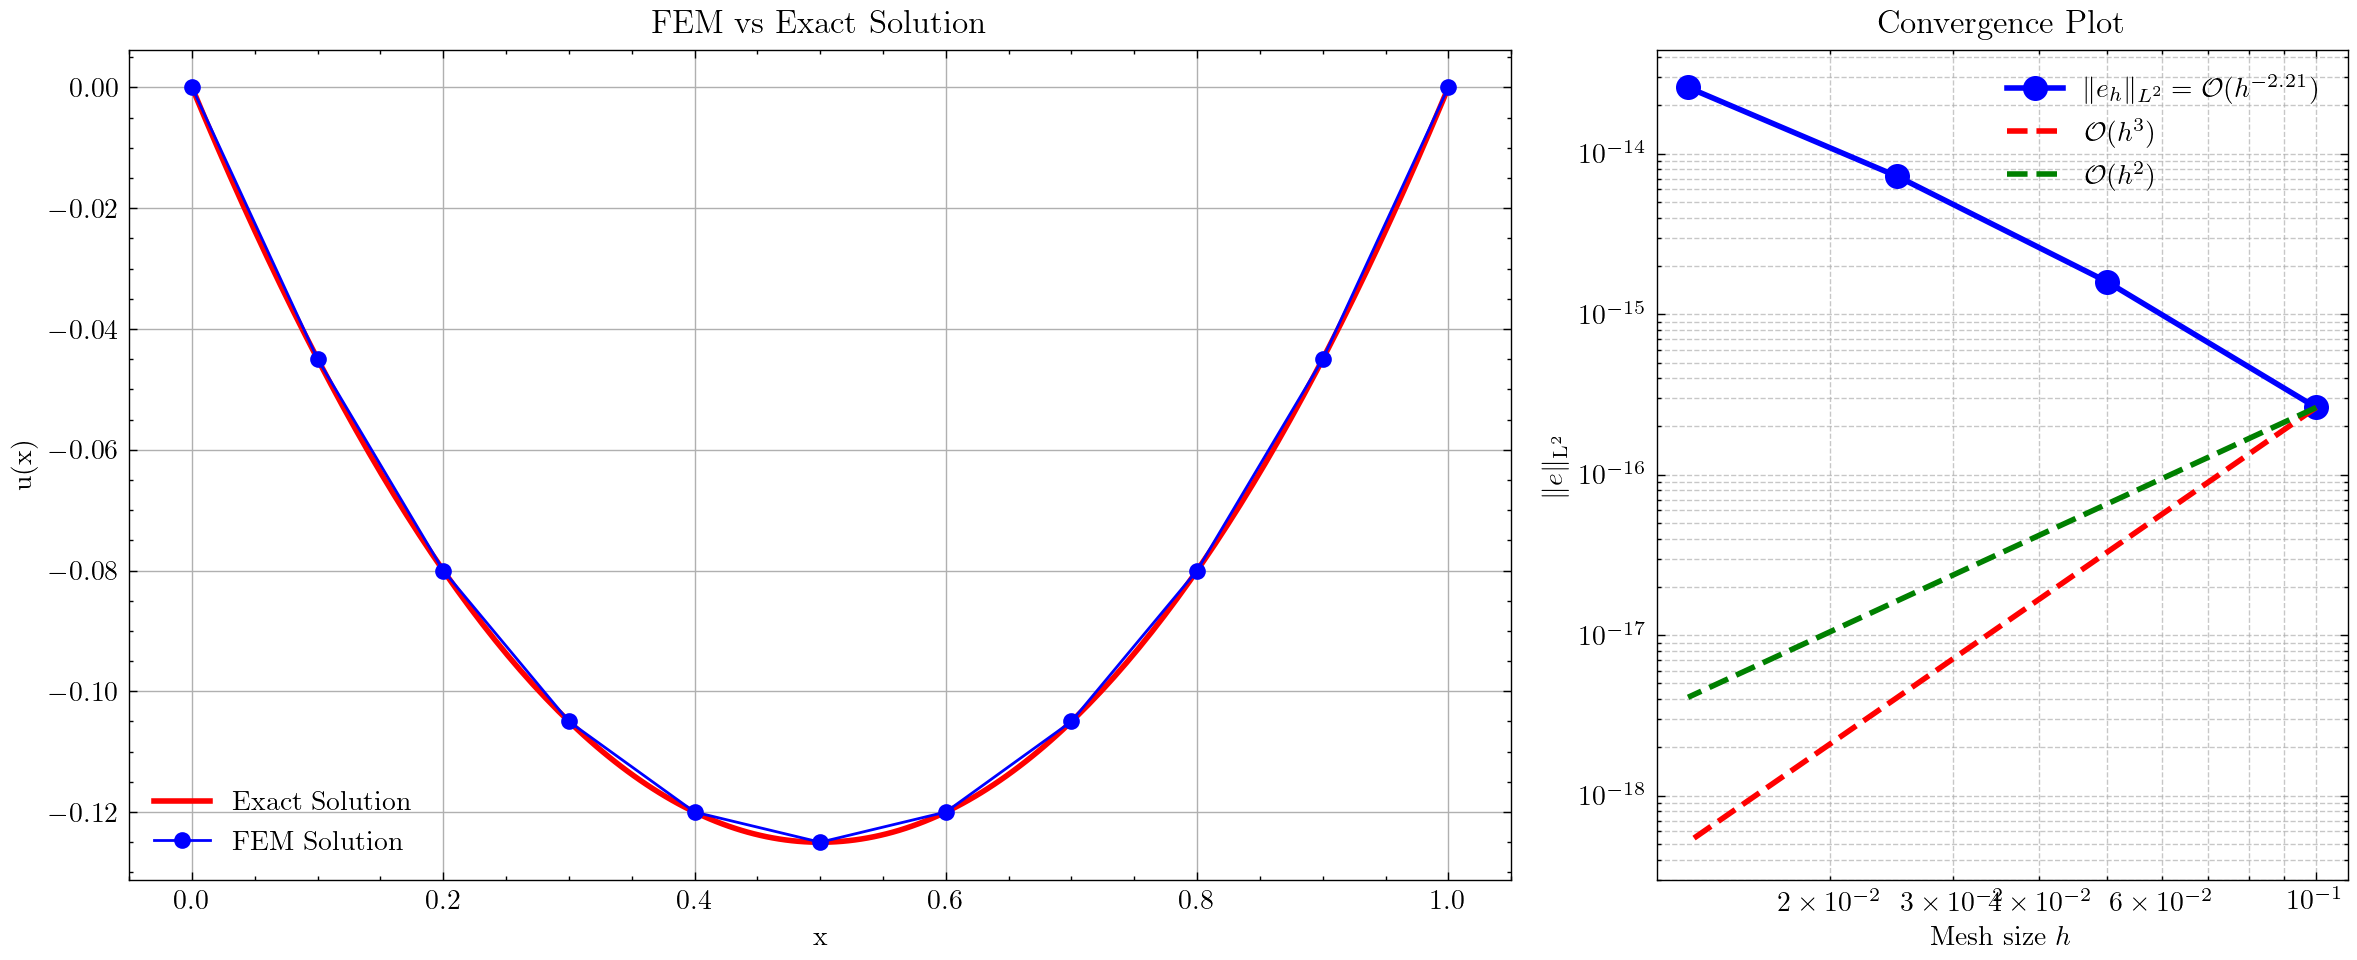

In [2]:

# Example usage:
M = 5
f = lambda x: -1.0
exact = lambda x: (1.0 / 2.0) * (x**2 - x)
solver = FEMPoissonSolver(M, f, exact)
solver.assemble()
solver.solve()
solver.plot(fine_mesh=200, name='1')

L2 Error (Test 5): 0.0002991531618197061


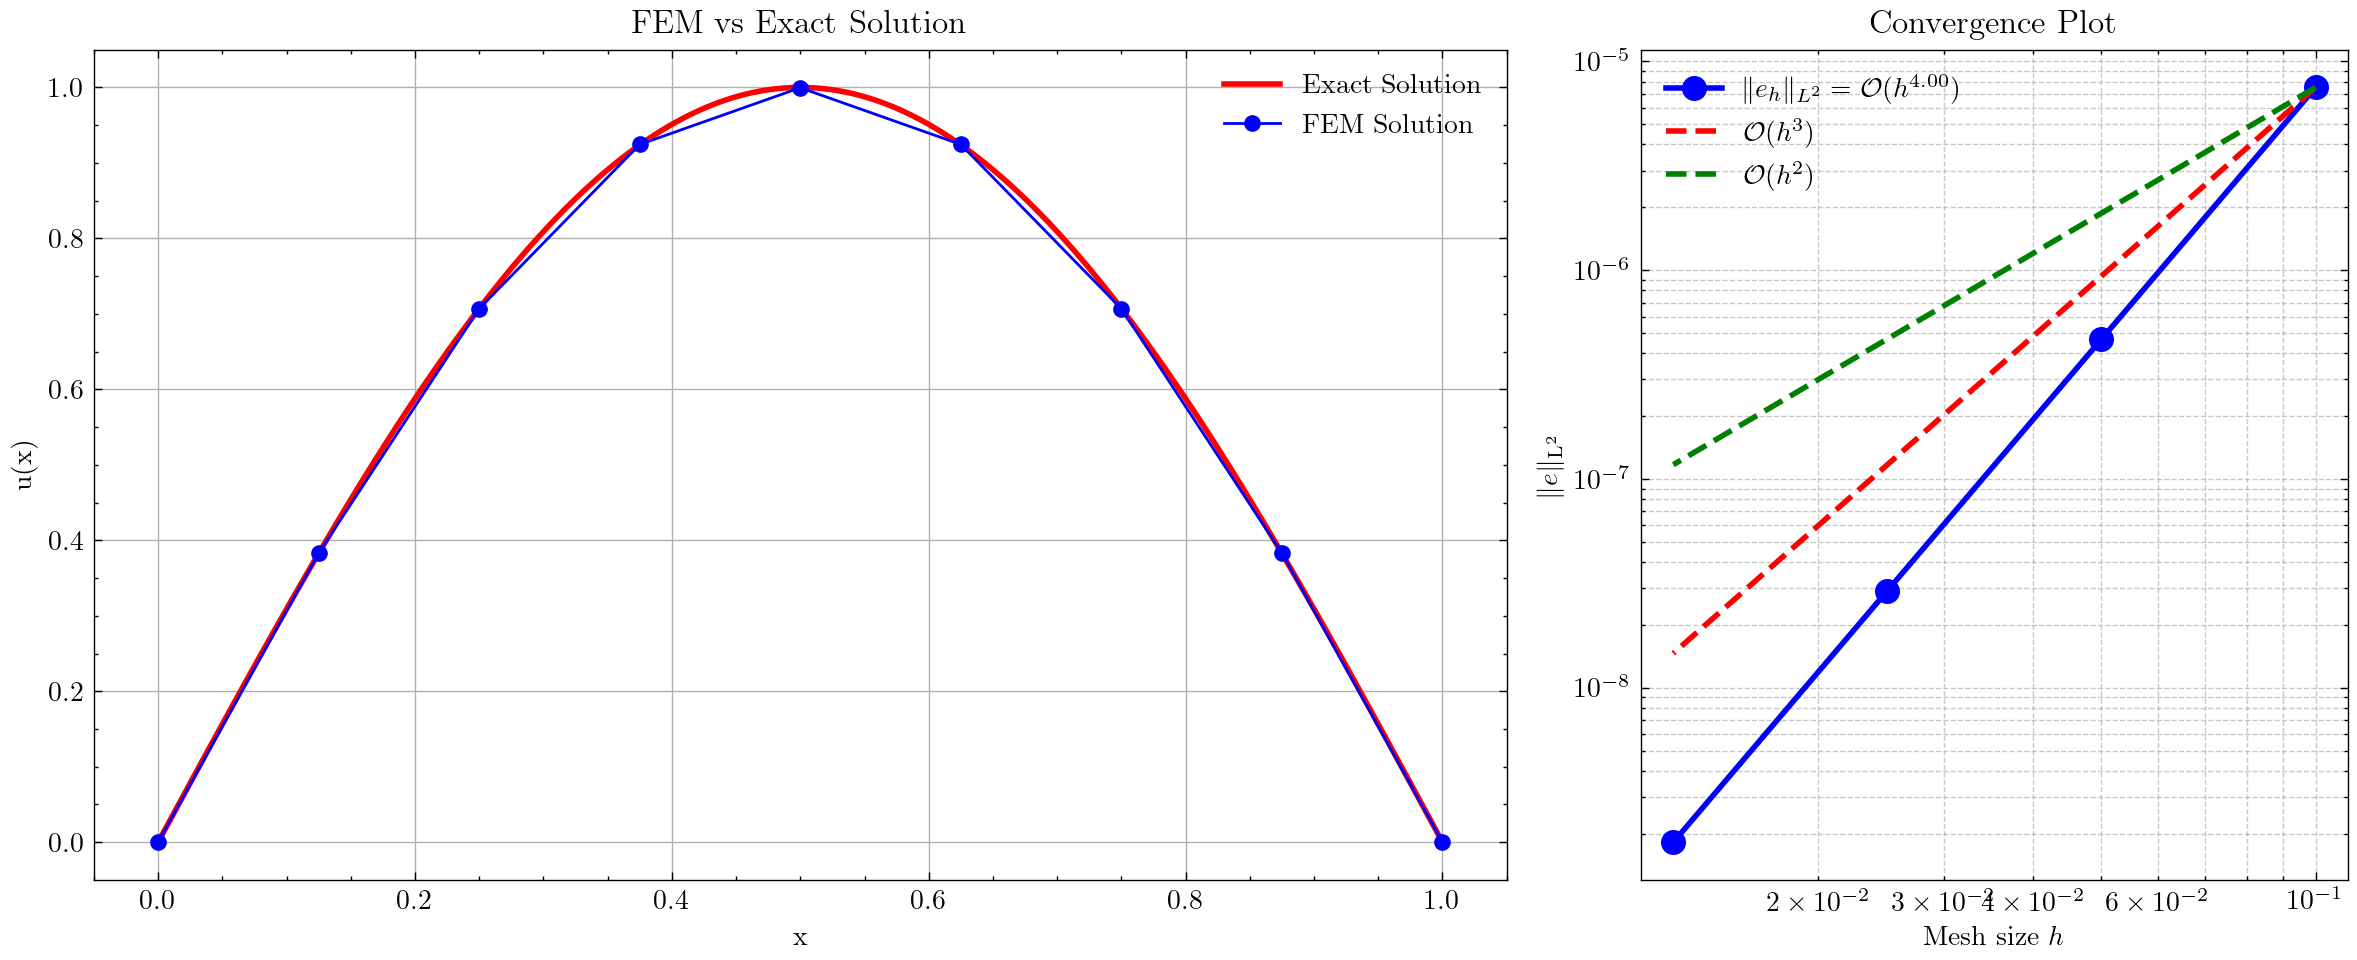

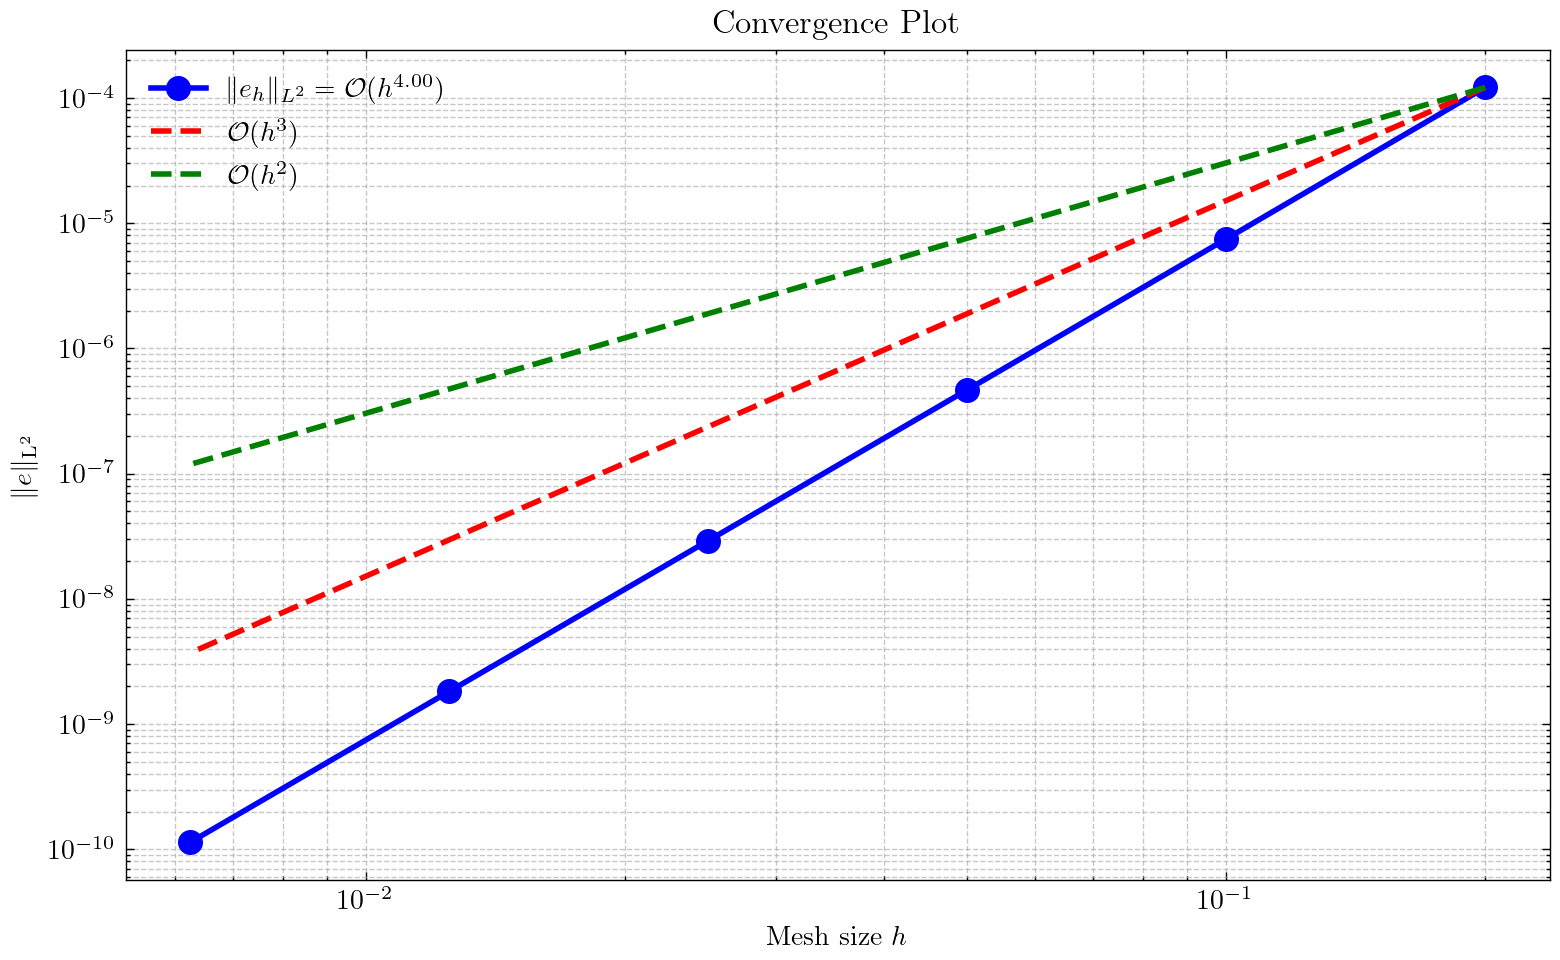

In [3]:

f2 = lambda x: np.pi**2 * np.sin(np.pi*x)
exact2 = lambda x: np.sin(np.pi*x)
solver2 = FEMPoissonSolver(M=4, f=f2, exact=exact2)
solver2.assemble()
solver2.solve()
print("L2 Error (Test 5):", solver2.L2_error())
solver2.plot(fine_mesh=200, name='2')
solver2.plot_convergence(name='2')

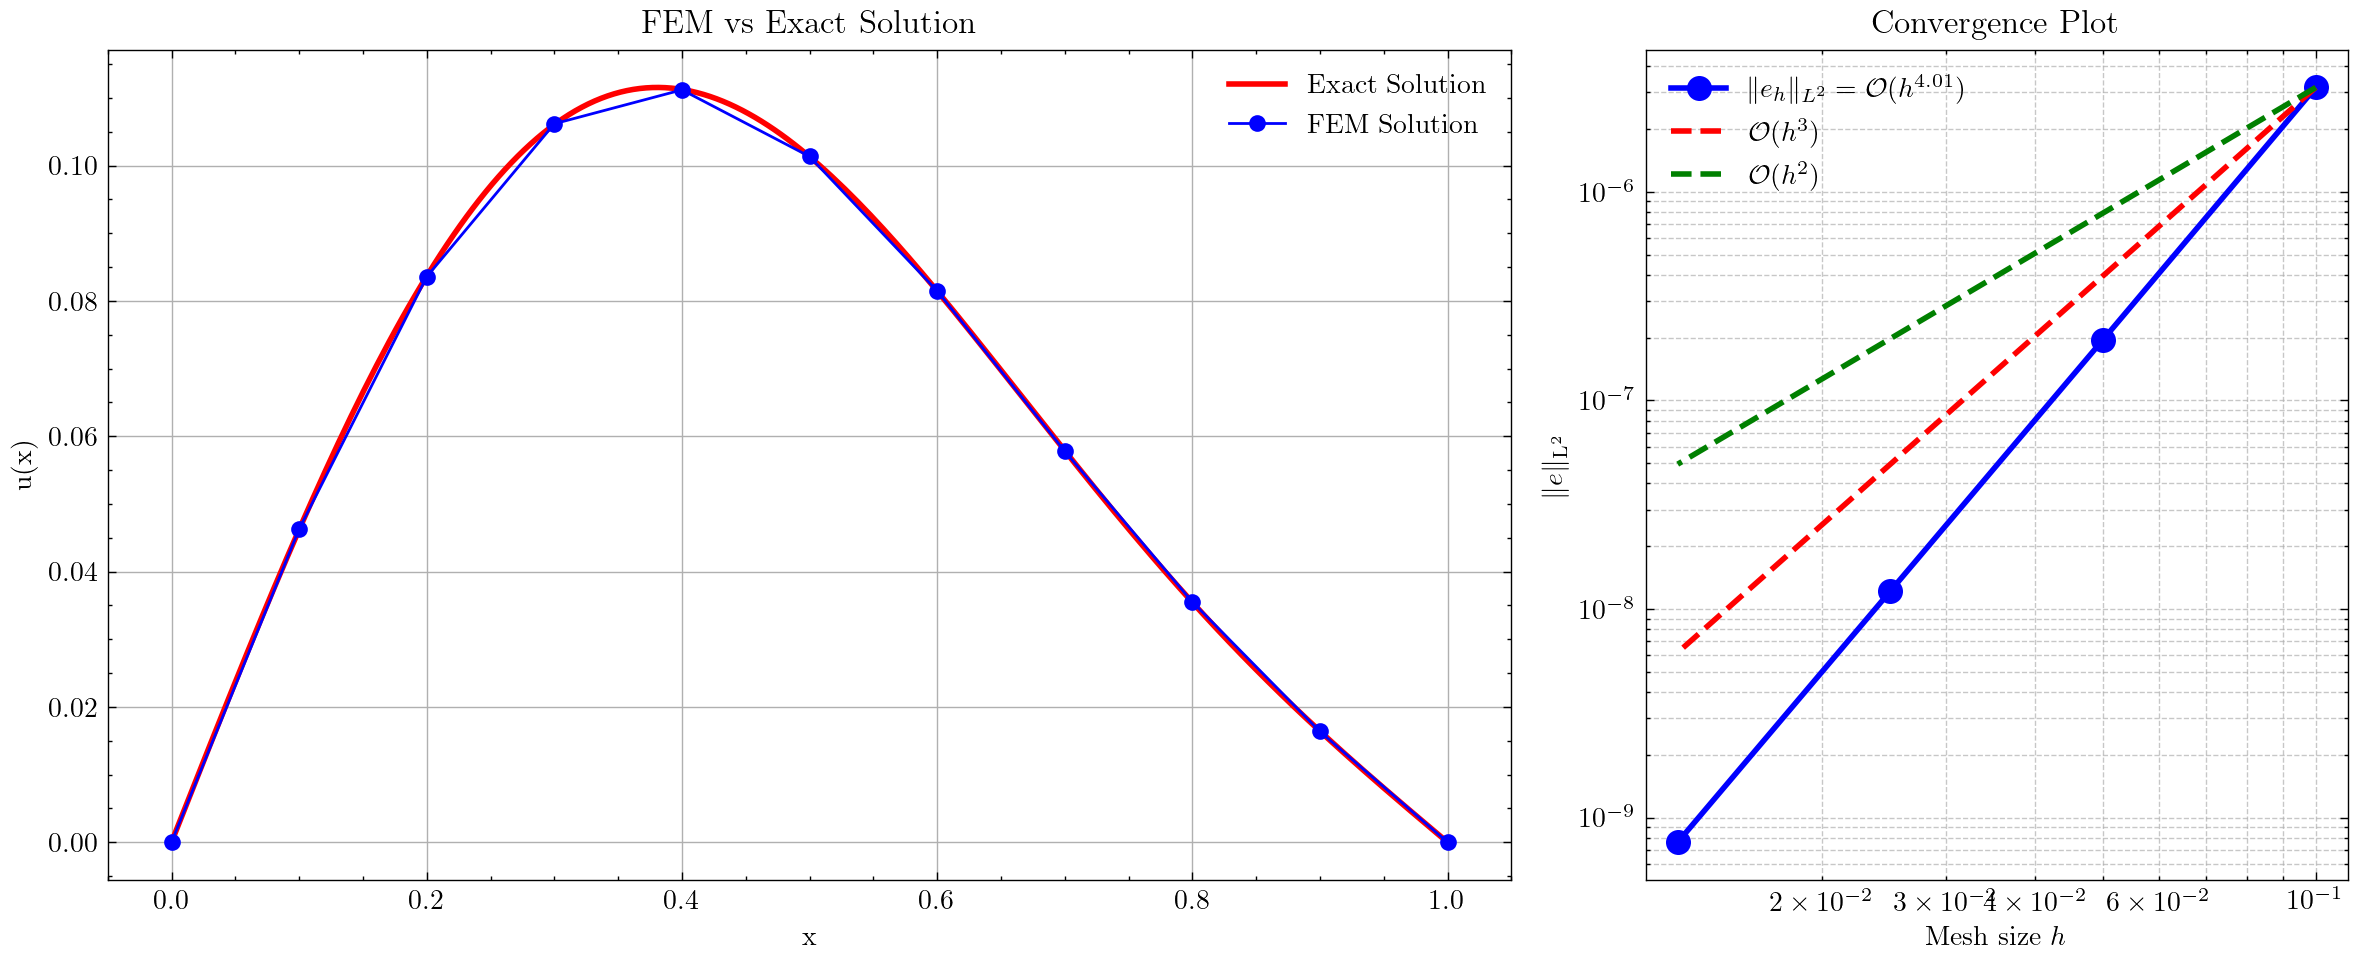

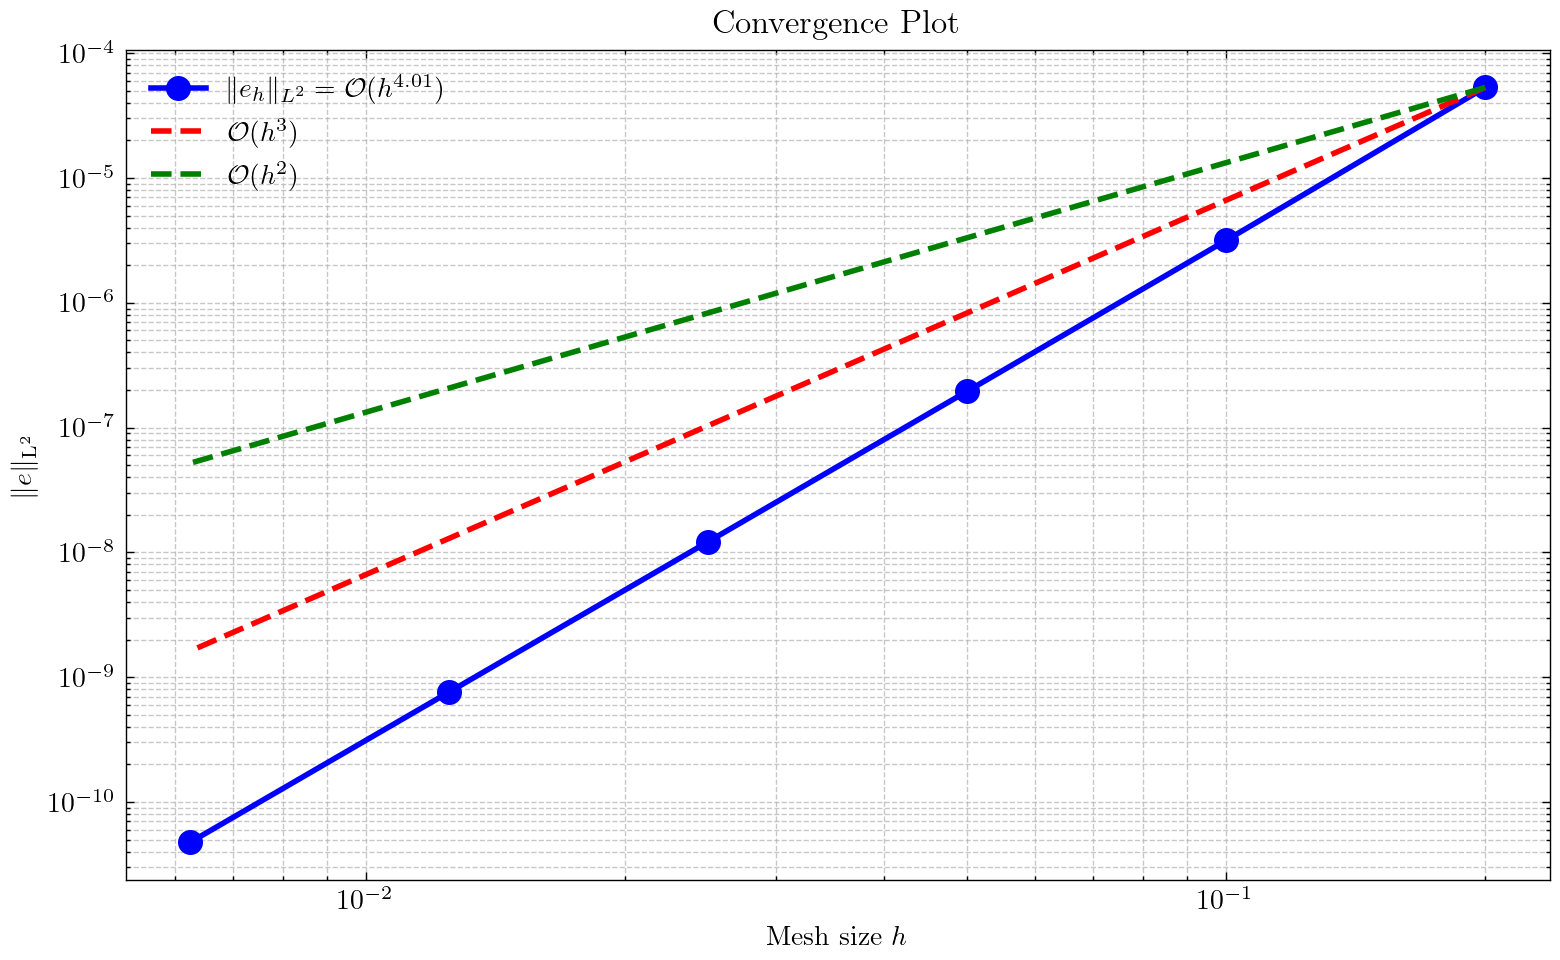

In [4]:

def u_exact_test4(x):
    return (1.0 / (np.pi**2)) * np.sin(np.pi * x) + (1.0 / (4 * np.pi**2)) * np.sin(2 * np.pi * x)
def f_test4(x):
    return np.sin(np.pi * x) + np.sin(2 * np.pi * x)
solver4 = FEMPoissonSolver(M=5, f=f_test4, exact=u_exact_test4)
solver4.assemble()
solver4.solve()
solver4.plot(fine_mesh=200, name='4')
solver4.plot_convergence(name='4')


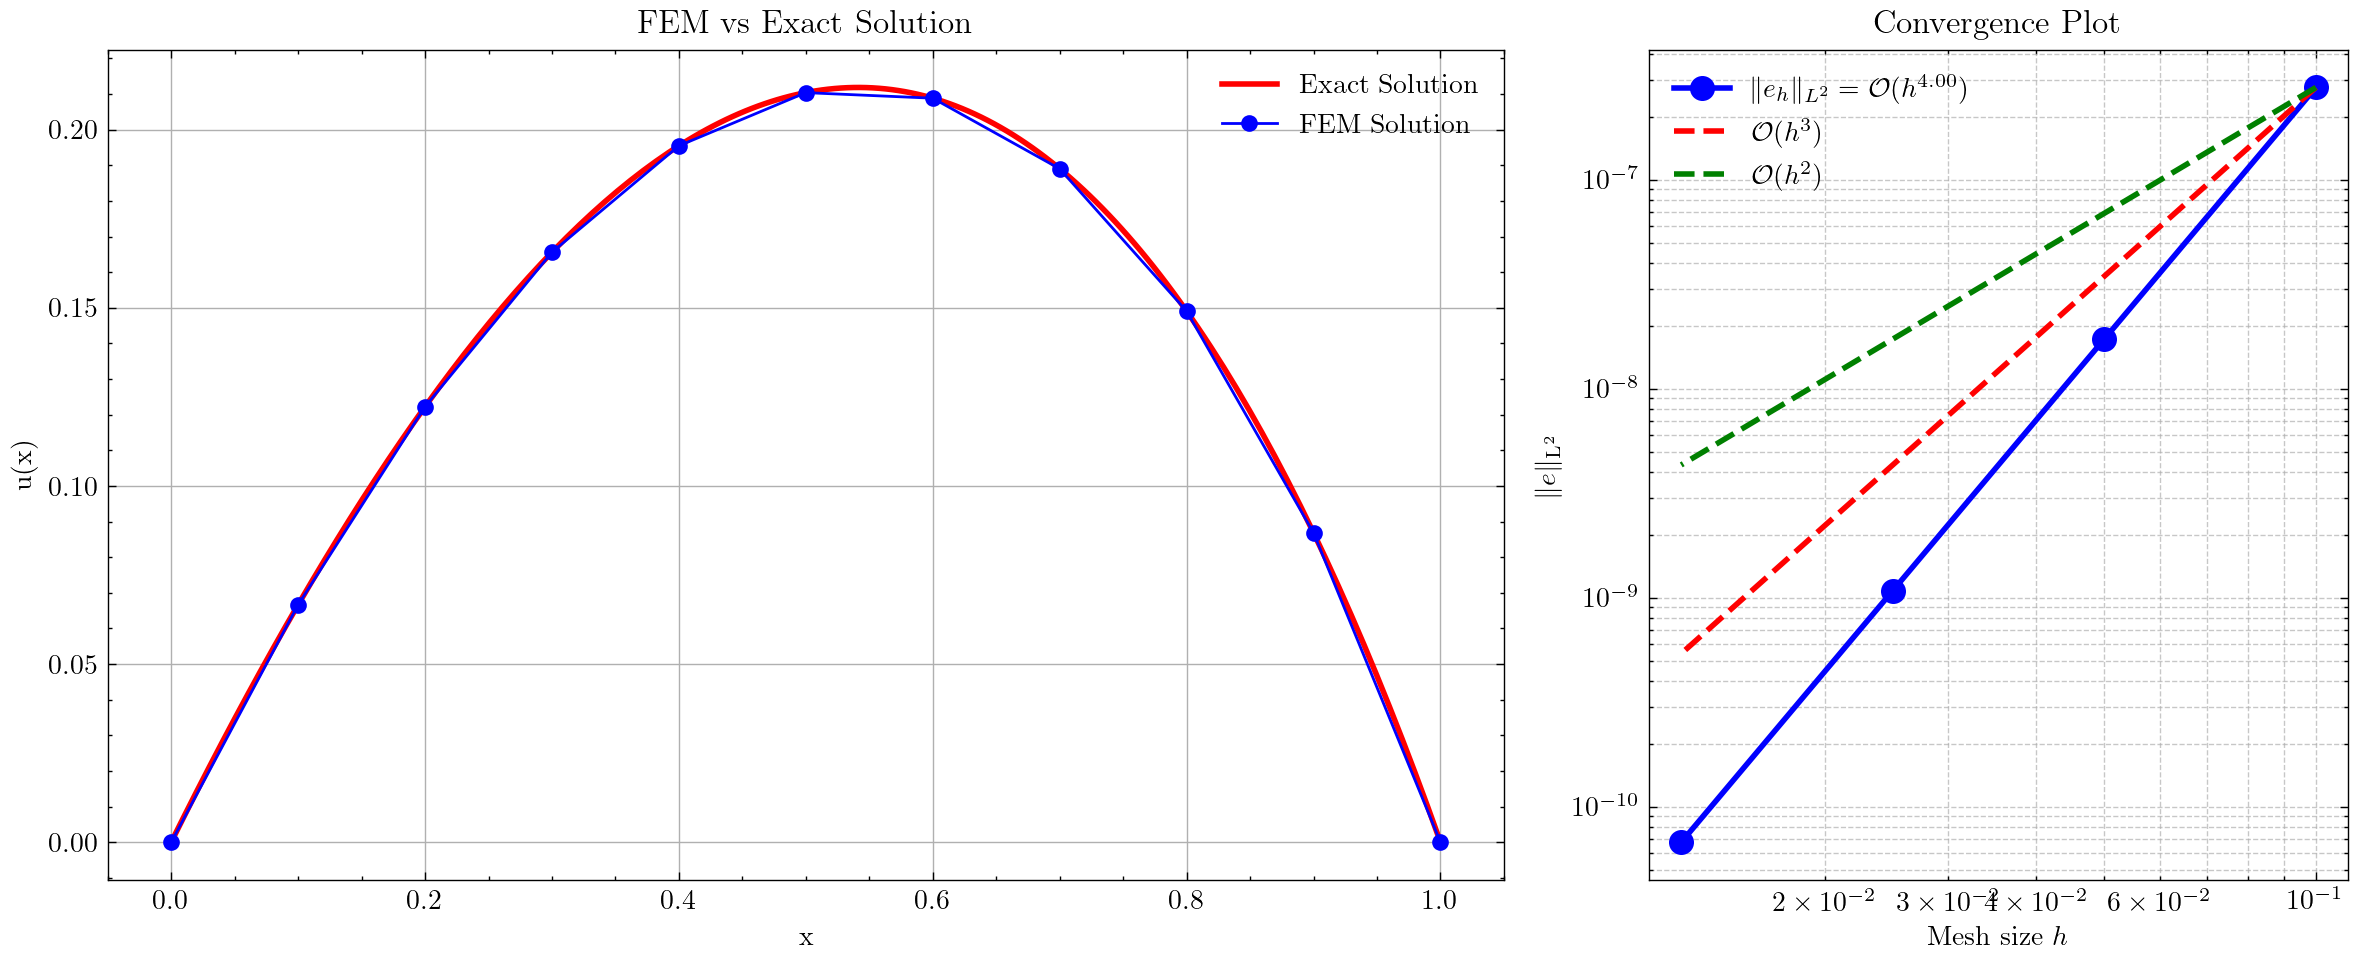

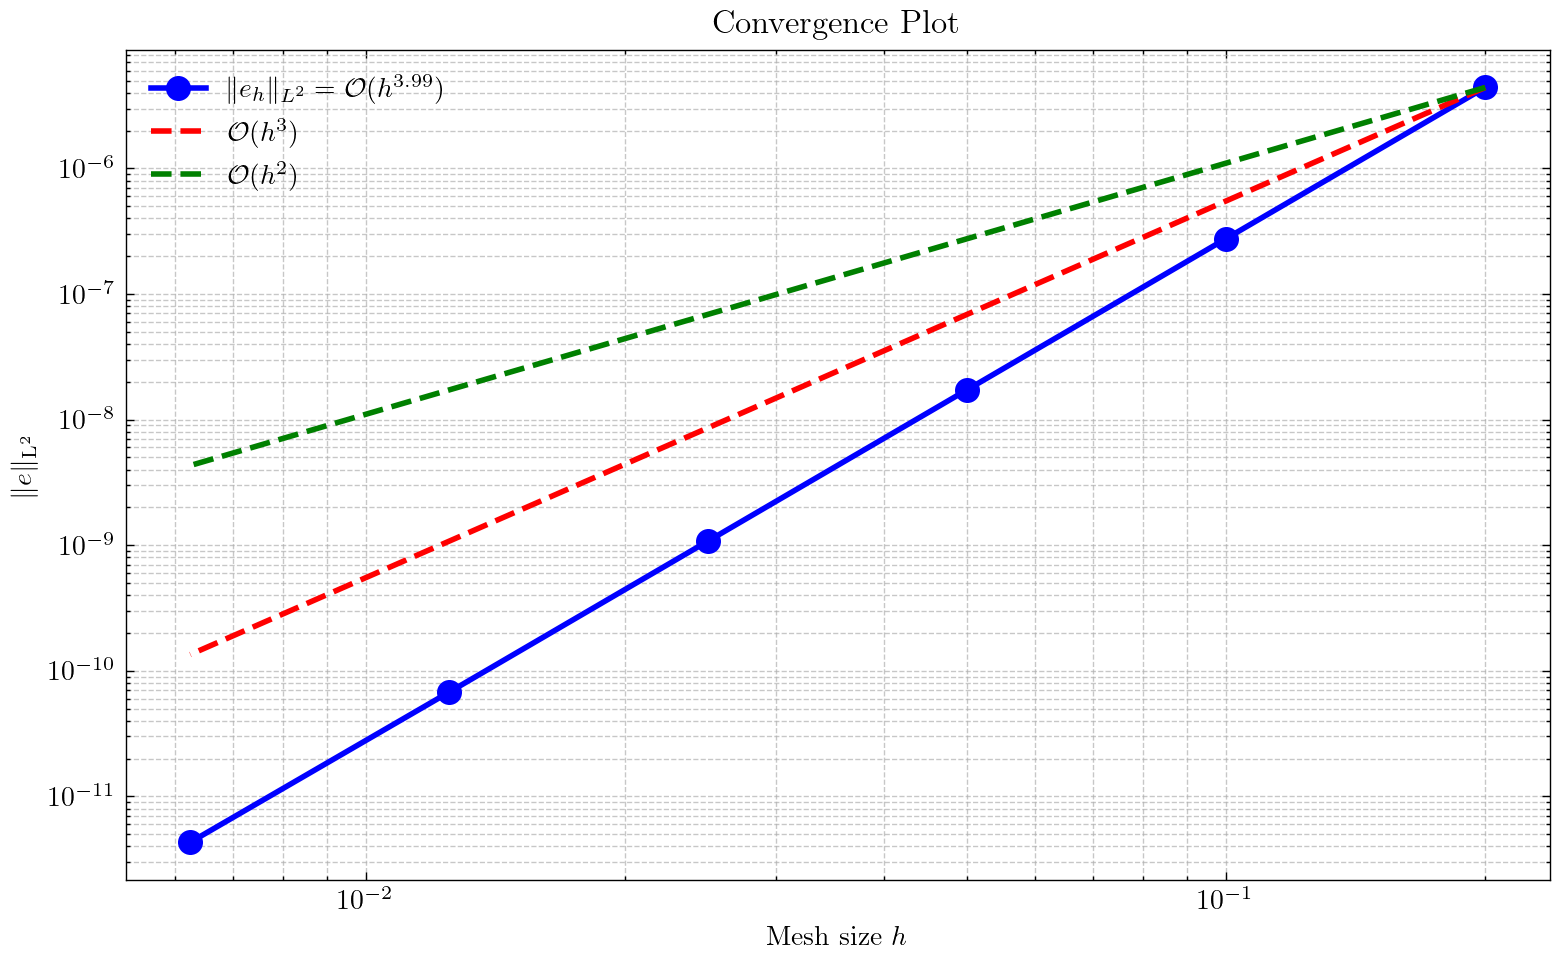

In [5]:
def f_test3(x): return np.exp(x)
def u_exact_test3(x): return -np.exp(x) + (np.e - 1)*x + 1

solver3 = FEMPoissonSolver(M=5, f=f_test3, exact=u_exact_test3)
solver3.assemble()
solver3.solve()
solver3.plot(fine_mesh=200, name='5')
solver3.plot_convergence(name='5')


In [6]:
def f(x):
    return np.pi**2 * np.sin(np.pi*x)

# Define mesh (example: non-uniform points or uniform linspace)
x_nodes = np.array([0, 0.2, 0.5, 0.7, 1.0])  # example non-uniform mesh
N = len(x_nodes) - 1

# Assign global indices for interior node and midpoint DoFs
node_index = [-1] * (N + 1)
mid_index = [None] * N
glob_idx = 0
for j in range(1, N):       # interior nodes
    node_index[j] = glob_idx
    glob_idx += 1
for i in range(N):          # midpoints
    mid_index[i] = glob_idx
    glob_idx += 1

# Initialize global stiffness matrix K and load vector F
size = glob_idx
K = np.zeros((size, size))
F = np.zeros(size)

# Assemble the global stiffness matrix and load vector
psi_vals = {0: np.array([1, 0, 0]),
            0.5: np.array([0, 1, 0]),
            1: np.array([0, 0, 1])}
psi_prime = {0: np.array([-3, 4, -1]),
             0.5: np.array([-1, 0, 1]),
             1: np.array([1, -4, 3])}

for i in range(N):
    h_i = x_nodes[i+1] - x_nodes[i]
    # Element stiffness via Simpson's rule on reference [0,1]:
    for a in range(3):
        for b in range(3):
            # Simpson's rule with reference shape function derivatives
            val0 = psi_prime[0][a] * psi_prime[0][b]
            valm = psi_prime[0.5][a] * psi_prime[0.5][b]
            val1 = psi_prime[1][a] * psi_prime[1][b]
            K_elem = (val0 + 4*valm + val1) * (1 / (6 * h_i))  # 1/h  (1/6)[...]
            # Map local (a, b) to global indices
            p = node_index[i] if a == 0 else (mid_index[i] if a == 1 else node_index[i+1])
            q = node_index[i] if b == 0 else (mid_index[i] if b == 1 else node_index[i+1])
            if p != -1 and q != -1:  # both are interior unknowns
                K[p, q] += K_elem
    # Element load vector via Simpson's rule
    f_left  = f(x_nodes[i])
    f_mid   = f((x_nodes[i] + x_nodes[i+1]) / 2)
    f_right = f(x_nodes[i+1])
    F_elem = np.array([f_left, 4 *f_mid, f_right]) * (h_i / 6)
    # Add to global F
    for a in range(3):
        p = node_index[i] if a == 0 else (mid_index[i] if a == 1 else node_index[i+1])
        if p != -1:
            F[p] += F_elem[a]

# Solve KU = F for unknown coefficients U
U = np.linalg.solve(K, F)
U


array([0.58769992, 0.99940564, 0.80835105, 0.30909934, 0.89248395,
       0.9508111 , 0.45458348])

<Figure size 350x262.5 with 0 Axes>

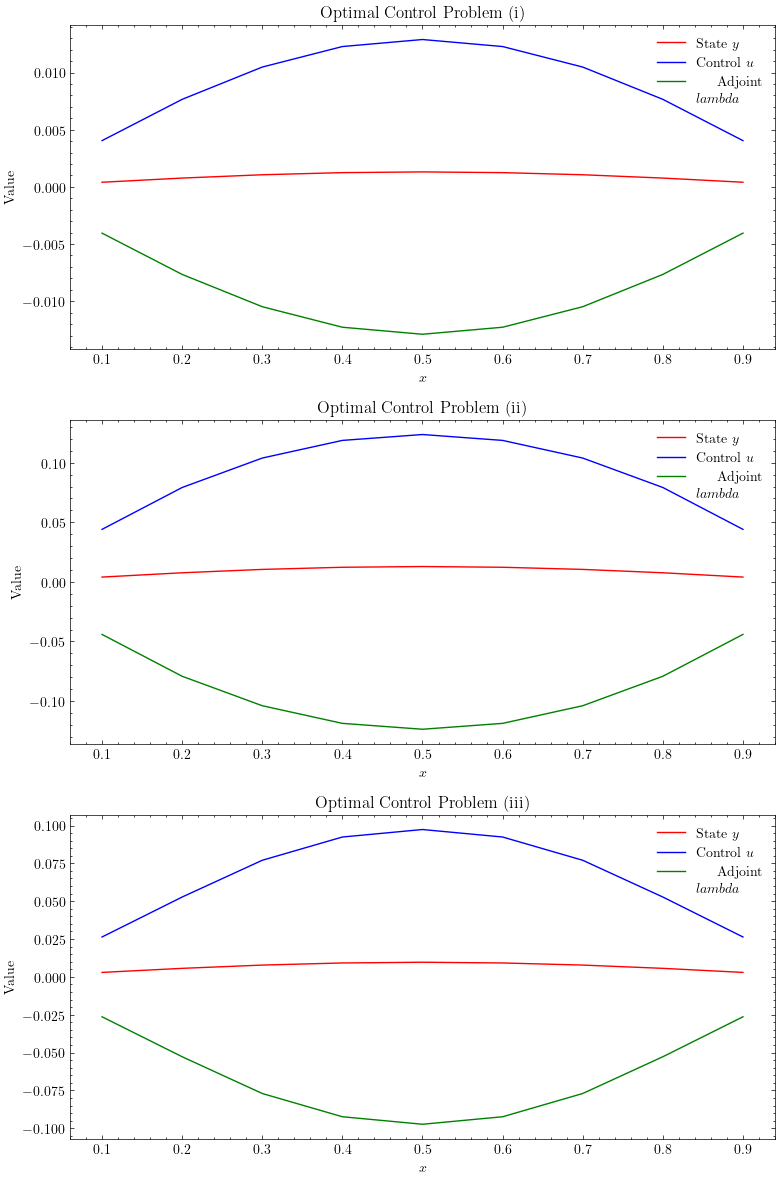

In [10]:

def assemble_FEM_matrices(N):
    """Assemble stiffness matrix B and mass matrix M (size 2N-1) for P2 elements on [0,1]."""
    # Coordinates of nodes (including boundaries and midpoints)
    # There are 2N+1 nodes (including boundaries); interior nodes indexed 1..2N-1
    coords = np.zeros(2*N + 1)
    h = 1.0 / N
    for k in range(N):  # for each element
        coords[2*k] = k * h        # element left endpoint
        coords[2*k + 1] = k*h + h/2  # midpoint
    coords[2*N] = 1.0  # right boundary
    
    # Reference element integrals for P2 (from analytical derivation)
    B_ref = np.array([[7/3,  -8/3,  1/3],
                      [-8/3, 16/3, -8/3],
                      [1/3,  -8/3,  7/3]], dtype=float)
    M_ref = np.array([[ 2/15,  1/15, -1/30],
                      [ 1/15,  8/15,  1/15],
                      [-1/30,  1/15,  2/15]], dtype=float)
    
    # Initialize global matrices (size 2N+1 including boundaries)
    B_full = np.zeros((2*N+1, 2*N+1))
    M_full = np.zeros((2*N+1, 2*N+1))
    # Assembly: add each element's contribution
    for k in range(N):
        # nodes of element k: global indices [2k, 2k+1, 2k+2]
        elem_nodes = [2*k, 2*k+1, 2*k+2]
        h_e = coords[2*k+2] - coords[2*k]  # element length
        # Local matrices scaled by h
        B_loc = (1.0/h_e) * B_ref
        M_loc = h_e * M_ref
        # Add to global matrix
        for a in range(3):
            i = elem_nodes[a]
            for b in range(3):
                j = elem_nodes[b]
                B_full[i,j] += B_loc[a,b]
                M_full[i,j] += M_loc[a,b]
    # Remove boundary rows/cols (Dirichlet 0 at nodes 0 and 2N)
    B = B_full[1:2*N, 1:2*N]
    M = M_full[1:2*N, 1:2*N]
    return coords[1:2*N], B, M  # return interior node coords and matrices

def solve_optimal_control(y_d_func, alpha, N):
    """Solve the optimal control problem for given desired profile function y_d_func and parameter alpha."""
    coords_int, B, M = assemble_FEM_matrices(N)
    # Build discrete target vector (interpolate y_d at interior nodes)
    y_d_vals = y_d_func(coords_int)
    # Solve reduced system: (M B^{-1} M + alpha B) u = M y_d
    # We do this by solving B X = M for X (equivalent to X = B^{-1} M)
    X = np.linalg.solve(B, M)              # solve B * X = M
    A = M.dot(X) + alpha * B               # form M B^{-1} M + alpha B
    rhs = M.dot(y_d_vals)                  # right-hand side M * y_d
    u = np.linalg.solve(A, rhs)            # solve for control coefficients
    y = np.linalg.solve(B, M.dot(u))       # solve B y = M u for state coefficients
    lam = -alpha * u                       # adjoint from optimality condition
    return coords_int, y, u, lam

# Define desired profiles as Python functions for convenience:
y_d1 = lambda x: 0.5 * x * (1 - x)                      # Case (i)
y_d2 = lambda x: np.ones_like(x)                       # Case (ii)
y_d3 = lambda x: np.where((0.25 <= x) & (x <= 0.75), 1.0, 0.0)  # Case (iii)

# Solve optimal control problem for each case
alpha = 1.0
N = 5
coords_int1, y1, u1, lam1 = solve_optimal_control(y_d1, alpha, N)
coords_int2, y2, u2, lam2 = solve_optimal_control(y_d2, alpha, N)
coords_int3, y3, u3, lam3 = solve_optimal_control(y_d3, alpha, N)
# Plot results for each case
plt.clf()
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].plot(coords_int1, y1, 'r-', label=r'State $y$')
axs[0].plot(coords_int1, u1, 'b-', label=r'Control $u$')
axs[0].plot(coords_int1, lam1, 'g-', label=r'Adjoint $\\lambda$')
axs[0].set_title('Optimal Control Problem (i)')
axs[0].legend()
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel('Value')
axs[1].plot(coords_int2, y2, 'r-', label=r'State $y$')
axs[1].plot(coords_int2, u2, 'b-', label=r'Control $u$')
axs[1].plot(coords_int2, lam2, 'g-', label=r'Adjoint $\\lambda$')
axs[1].set_title('Optimal Control Problem (ii)')
axs[1].legend()
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel('Value')
axs[2].plot(coords_int3, y3, 'r-', label=r'State $y$')
axs[2].plot(coords_int3, u3, 'b-', label=r'Control $u$')
axs[2].plot(coords_int3, lam3, 'g-', label=r'Adjoint $\\lambda$')
axs[2].set_title('Optimal Control Problem (iii)')
axs[2].legend()
axs[2].set_xlabel(r'$x$')
axs[2].set_ylabel('Value')
plt.tight_layout()
plt.show()
